# Developing the Geodescriber

## Title

Load a geostore via LMIPy. Use OSM revese geocoding to generate data for bounds of a geometry. Create a title based on the agreement between the bounds.

## EE query

## Dynamic Paragraph creation

## Translate to a different language

Use Translation service to return response in a target language.

In [213]:
#!pip install geocoder
#!pip install translate
#!pip install LMIPy
#!pip install earthengine-api
#!pip install oauth2client

In [214]:
import geocoder                   # https://geocoder.readthedocs.io/
from translate import Translator  # https://pypi.org/project/translate/
import LMIPy

In [90]:
# Area between spain and france

atts={'geojson': {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'properties': {},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-0.87890625, 43.329173667843904],
       [-1.6149902343749998, 42.75104599038353],
       [-1.1865234375, 42.35854391749705],
       [-0.6427001953125, 42.755079545072135],
       [-0.45043945312499994, 42.9524020856897],
       [-0.87890625, 43.329173667843904]]]}}]}}

g1 = LMIPy.Geometry(attributes=atts, server='http://localhost:9000')
g1

Geometry f6726c97139f362ca9a10d70dc686375

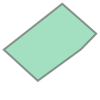

In [91]:
g1.shape()[0]

In [79]:
# Weird area in Spain

atts= {'geojson': {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'properties': {},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-4.866943359375, 41.69752591075902],
       [-5.756835937499999, 41.31907562295139],
       [-5.592041015625, 41.08763212467916],
       [-4.89990234375, 41.13729606112276],
       [-4.7021484375, 41.08763212467916],
       [-4.41650390625, 40.57224011776902],
       [-4.72412109375, 40.12849105685408],
       [-5.042724609375, 39.926588421909436],
       [-5.218505859375, 39.58029027440865],
       [-4.801025390625, 39.36827914916014],
       [-4.02099609375, 39.37677199661635],
       [-3.7902832031250004, 40.07807142745009],
       [-4.02099609375, 40.522150985623796],
       [-4.515380859375, 41.104190944576466],
       [-4.383544921875, 41.376808565702355],
       [-4.32861328125, 41.65649719441145],
       [-4.866943359375, 41.69752591075902]]]}}]}}

g2 = LMIPy.Geometry(attributes=atts, server='http://localhost:9000')
g2

Geometry aaea7cd252ee33cab3f31ae975db8f47

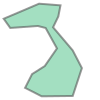

In [83]:
g2.shape()[0]

In [191]:
# Worker functions for generating a title 

def reverse_geocode_a_geostore(geostore):
    """ Take an LMIPy.Geostore object and return geocoding results on the min/max coordinate locations"""
    s = geostore.shape()[0]
    min_coords = [s.bounds[1], s.bounds[0]]
    max_coords = [s.bounds[3], s.bounds[2]]
    geocode_results = []
    for coords in [min_coords, max_coords]:
        geocode_results.append(geocoder.osm(coords, method='reverse'))
    return geocode_results

def create_title(geostore):
    """Take revsere geocoding results for upper and lower corners of a polygons bounds,
        Extract the region, county, country, continent attributes of the locations.
        Use the overlap to set an appropriate title. 
    """
    geocode_results = reverse_geocode_a_geostore(geostore)
    key_locations = []
    for result in geocode_results:
        d = {}
        try:  
            d['region'] = result.geojson.get('features')[0].get('properties').get('region')
        except:
            d['region'] = None
        try:
            d['county'] = result.geojson.get('features')[0].get('properties').get('county')
        except:
            d['county'] = None
        try:
            d['country'] = result.geojson.get('features')[0].get('properties').get('country')
        except:
            d['country'] = None
        try:
            d['continent'] = continent_lookup[iso_to_continent[result.geojson.get('features')[0].get('properties').get('country_code').upper()]]
        except:
            d['continent'] = None
        key_locations.append(d)
    # Check for overlap between upper and lower bounds
    same_region = key_locations[0].get('region') == key_locations[1].get('region')
    same_county = key_locations[0].get('county') == key_locations[1].get('county')
    same_country = key_locations[0].get('country') == key_locations[1].get('country')
    same_continent = key_locations[0].get('continent') == key_locations[1].get('continent')
    # Set a title
    if same_region:
        title= f"Area in {key_locations[0]['region']} {key_locations[0]['county']}, {key_locations[0]['country']}, {key_locations[0]['continent']}"
    elif same_county:
        title= f"Area in {key_locations[0]['county']}, {key_locations[0]['country']}, {key_locations[0]['continent']}"
    elif same_country:
        title = f"Area in {key_locations[0]['country']}, {key_locations[0]['continent']}"
    elif same_continent:
        title = f"Area in {key_locations[0]['continent']}"
    else:
        title = None
    return title

In [147]:
geocode_results = reverse_geocode_a_geostore(geostore)
geocode_results

[<[OK] Osm - Reverse [Carretera de Plasencia a Zorita, Herguijuela, Cáceres, Extremadura, España]>,
 <[OK] Osm - Reverse [CL-619, Villalba de Duero, Ribera del Duero, Burgos, Castilla y León, 09443, España]>]

In [195]:
geostore1 = LMIPy.Geometry('aaea7cd252ee33cab3f31ae975db8f47', server='http://localhost:9000')

geostore1

Geometry aaea7cd252ee33cab3f31ae975db8f47

## Check speed of response and translation

N.b. title and paragraph should be translated together and split to save on requests

In [203]:
%%time
create_title(geostore1)

CPU times: user 53.3 ms, sys: 8.09 ms, total: 61.3 ms
Wall time: 457 ms


'Area in España, Europe'

In [217]:
translator= Translator(to_lang="es")
translation = translator.translate(title)
translation

'Area en España, Europa'

In [218]:
translator= Translator(to_lang="fr")
translation = translator.translate(title)
translation

'Zone à España, Europe'

In [204]:
geostore2 = LMIPy.Geometry('f6726c97139f362ca9a10d70dc686375', server='http://localhost:9000')
geostore2

Geometry f6726c97139f362ca9a10d70dc686375

In [219]:
# Test of geometry in RW API
g = LMIPy.Geometry('37bd82f55b0a98dca94a46ad7789e2a3')
title = create_title(g)
title

'Area in PA Microrregião de Itaituba, Brasil, South america'

In [220]:
translator.translate(title)

'Région de Microrregião de Itaituba, Brésil, Amérique du Sud'

## Earth Engine portion

In [227]:
import ee
ee.Initialize()

In [ ]:
# Step 1 - Build a layer with multiple bands which we can intersect against in EE
# Step 2 - Run a Zonal stats reducer on the area
# Step 3 - Create a decision tree and dynamic sentence

# Include: amount of tree cover area, elevation (split into categories), biogeophysical regions? land-cover classes? protected areas?

## Dependent/lookup info

In [177]:
continent_lookup = {'AF':'Africa',
                    'AN':'Antarctica',
                    'AS':'Asia',
                    'EU':'Europe',
                    'NA':'North america',
                    'OC':'Oceania',
                    'SA':'South america'}

In [176]:
iso_to_continent = {'AD':'EU',
'AE':'AS',
'AF':'AS',
'AG':'NA',
'AI':'NA',
'AL':'EU',
'AM':'AS',
'AO':'AF',
'AP':'AS',
'AN':'NA',
'AQ':'AN',
'AR':'SA',
'AS':'OC',
'AT':'EU',
'AU':'OC',
'AW':'NA',
'AX':'EU',
'AZ':'AS',
'BA':'EU',
'BB':'NA',
'BD':'AS',
'BE':'EU',
'BF':'AF',
'BG':'EU',
'BH':'AS',
'BI':'AF',
'BJ':'AF',
'BL':'NA',
'BM':'NA',
'BN':'AS',
'BO':'SA',
'BR':'SA',
'BS':'NA',
'BT':'AS',
'BV':'AN',
'BW':'AF',
'BY':'EU',
'BZ':'NA',
'CA':'NA',
'CC':'AS',
'CD':'AF',
'CF':'AF',
'CG':'AF',
'CH':'EU',
'CI':'AF',
'CK':'OC',
'CL':'SA',
'CM':'AF',
'CN':'AS',
'CO':'SA',
'CR':'NA',
'CU':'NA',
'CV':'AF',
'CX':'AS',
'CY':'AS',
'CZ':'EU',
'DE':'EU',
'DJ':'AF',
'DK':'EU',
'DM':'NA',
'DO':'NA',
'DZ':'AF',
'EC':'SA',
'EE':'EU',
'EG':'AF',
'EH':'AF',
'ER':'AF',
'ES':'EU',
'ET':'AF',
'EU':'EU',
'FI':'EU',
'FJ':'OC',
'FK':'SA',
'FM':'OC',
'FO':'EU',
'FR':'EU',
'FX':'EU',
'GA':'AF',
'GB':'EU',
'GD':'NA',
'GE':'AS',
'GF':'SA',
'GG':'EU',
'GH':'AF',
'GI':'EU',
'GL':'NA',
'GM':'AF',
'GN':'AF',
'GP':'NA',
'GQ':'AF',
'GR':'EU',
'GS':'AN',
'GT':'NA',
'GU':'OC',
'GW':'AF',
'GY':'SA',
'HK':'AS',
'HM':'AN',
'HN':'NA',
'HR':'EU',
'HT':'NA',
'HU':'EU',
'ID':'AS',
'IE':'EU',
'IL':'AS',
'IM':'EU',
'IN':'AS',
'IO':'AS',
'IQ':'AS',
'IR':'AS',
'IS':'EU',
'IT':'EU',
'JE':'EU',
'JM':'NA',
'JO':'AS',
'JP':'AS',
'KE':'AF',
'KG':'AS',
'KH':'AS',
'KI':'OC',
'KM':'AF',
'KN':'NA',
'KP':'AS',
'KR':'AS',
'KW':'AS',
'KY':'NA',
'KZ':'AS',
'LA':'AS',
'LB':'AS',
'LC':'NA',
'LI':'EU',
'LK':'AS',
'LR':'AF',
'LS':'AF',
'LT':'EU',
'LU':'EU',
'LV':'EU',
'LY':'AF',
'MA':'AF',
'MC':'EU',
'MD':'EU',
'ME':'EU',
'MF':'NA',
'MG':'AF',
'MH':'OC',
'MK':'EU',
'ML':'AF',
'MM':'AS',
'MN':'AS',
'MO':'AS',
'MP':'OC',
'MQ':'NA',
'MR':'AF',
'MS':'NA',
'MT':'EU',
'MU':'AF',
'MV':'AS',
'MW':'AF',
'MX':'NA',
'MY':'AS',
'MZ':'AF',
'NA':'AF',
'NC':'OC',
'NE':'AF',
'NF':'OC',
'NG':'AF',
'NI':'NA',
'NL':'EU',
'NO':'EU',
'NP':'AS',
'NR':'OC',
'NU':'OC',
'NZ':'OC',
'O1':'--',
'OM':'AS',
'PA':'NA',
'PE':'SA',
'PF':'OC',
'PG':'OC',
'PH':'AS',
'PK':'AS',
'PL':'EU',
'PM':'NA',
'PN':'OC',
'PR':'NA',
'PS':'AS',
'PT':'EU',
'PW':'OC',
'PY':'SA',
'QA':'AS',
'RE':'AF',
'RO':'EU',
'RS':'EU',
'RU':'EU',
'RW':'AF',
'SA':'AS',
'SB':'OC',
'SC':'AF',
'SD':'AF',
'SE':'EU',
'SG':'AS',
'SH':'AF',
'SI':'EU',
'SJ':'EU',
'SK':'EU',
'SL':'AF',
'SM':'EU',
'SN':'AF',
'SO':'AF',
'SR':'SA',
'ST':'AF',
'SV':'NA',
'SY':'AS',
'SZ':'AF',
'TC':'NA',
'TD':'AF',
'TF':'AN',
'TG':'AF',
'TH':'AS',
'TJ':'AS',
'TK':'OC',
'TL':'AS',
'TM':'AS',
'TN':'AF',
'TO':'OC',
'TR':'EU',
'TT':'NA',
'TV':'OC',
'TW':'AS',
'TZ':'AF',
'UA':'EU',
'UG':'AF',
'UM':'OC',
'US':'NA',
'UY':'SA',
'UZ':'AS',
'VA':'EU',
'VC':'NA',
'VE':'SA',
'VG':'NA',
'VI':'NA',
'VN':'AS',
'VU':'OC',
'WF':'OC',
'WS':'OC',
'YE':'AS',
'YT':'AF',
'ZA':'AF',
'ZM':'AF',
'ZW':'AF'}